# Trading Rules

- Market: Rusell 1000

- Define the trend: Stock above the 200-day Moving Average

- Define the pullback: Stock closes 2.5 standard deviation below the 20-day Bollinger band

- Entry: Place a 3%  buy limit order below the previous day closing price

- Exit: 2-day RSI cross above 50 or after 10 trading days

In [1]:
import pandas as pd
import backtrader as bt
import yfinance as yf


In [44]:
data = pd.read_csv("BTCUSDT_2021-01-01.csv")
data["Date"] = pd.to_datetime(data["Date"], unit='ms')
data.set_index("Date",inplace=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01 00:13:20,28921.5,29026.0,28703.5,28990.0,28990.0,917.494
2021-01-01 00:13:20,28990.0,29505.5,28956.5,29411.0,29411.0,1927.830
2021-01-01 03:00:00,29411.0,29462.0,29150.0,29218.0,29218.0,931.537
2021-01-01 03:00:00,29218.0,29358.5,29171.5,29303.0,29303.0,440.535
2021-01-01 03:00:00,29303.0,29397.5,29078.0,29229.5,29229.5,711.549
...,...,...,...,...,...,...
2022-08-01 21:40:00,23117.0,23118.5,22964.5,23012.0,23012.0,3333.020
2022-08-01 21:40:00,23012.0,23180.0,22900.0,23150.0,23150.0,3999.116
2022-08-01 21:40:00,23150.0,23399.0,23149.5,23250.0,23250.0,8659.609


In [65]:
data = yf.download("MDB", start="2020-01-01", end="2022-09-30")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,130.179993,134.669998,126.080002,134.330002,134.330002,1166900
2020-01-03,132.429993,136.220001,131.759995,135.289993,135.289993,598300
2020-01-06,132.880005,140.889999,132.705002,140.500000,140.500000,1254600
2020-01-07,140.500000,142.610001,138.250000,138.860001,138.860001,672000
2020-01-08,138.899994,141.639999,136.229996,140.270004,140.270004,978800
...,...,...,...,...,...,...
2022-09-23,196.899994,201.350006,189.235001,194.729996,194.729996,2891400
2022-09-26,194.199997,200.500000,188.169998,189.690002,189.690002,1519900
2022-09-27,194.610001,197.949997,190.160004,194.440002,194.440002,1323700


In [66]:
data_parsed = bt.feeds.PandasData(dataname=data,
                             datetime=None,
                             open=0,
                             high=1,
                             low=2,
                             close=4,
                             volume=5,
                             openinterest=None)

In [67]:
class BollingerBandsStrategy(bt.Strategy):
    def __init__(self):
        self.params_exitbars = 10
        self.dataclose = self.datas[0].close # an array of historical price data
        self.sma200 = bt.indicators.SMA(self.dataclose, period=200)
        self.bb = bt.indicators.BollingerBands(self.dataclose, period=20,devfactor=2.5)
        self.rsi2 = bt.indicators.RSI(self.dataclose, period=2, safediv=True)
        self.order = None # to keep track of pending orders

    def next(self):
        if self.order:
            return
        elif not self.position:
            if self.data.close > self.sma200 and self.data.close < self.bb.bot[0]: # got other criteria?
                # Limit order - want to set the price 
                self.order = self.buy(exectype=bt.Order.Limit,
                                    price = self.data.close[0] * 0.97
                                    ) # place 0.3% limit order below the previous day closing price

        # sell only if you have the stock position
        elif self.rsi2 > 50 or len(self) >= (self.bar_executed + self.params_exitbars): # or after 10 trading days
            self.order = self.sell()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            # Write down: no pending order
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

In [71]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(1000000)
print(f'Starting portfolio value: {cerebro.broker.getvalue()}')
cerebro.broker.setcommission(commission=0.0005) # set commission to 0.1%
cerebro.addsizer(bt.sizers.PercentSizerInt, percents=100) # the system will use 100% of the money to invest
cerebro.adddata(data_parsed)
cerebro.addstrategy(BollingerBandsStrategy)
cerebro.run()

Starting portfolio value: 1000000
2021-03-04, BUY EXECUTED, 341.49
2021-03-10, SELL EXECUTED, 325.00
2021-12-03, BUY EXECUTED, 443.18
2021-12-08, SELL EXECUTED, 502.75
2022-01-06, BUY EXECUTED, 415.91
2022-01-12, SELL EXECUTED, 449.00


In [72]:
print(f'Ending portfolio value: {cerebro.broker.getvalue()}')

Ending portfolio value: 1157290.5189376774


In [ ]:
cerebro.add_order_history()

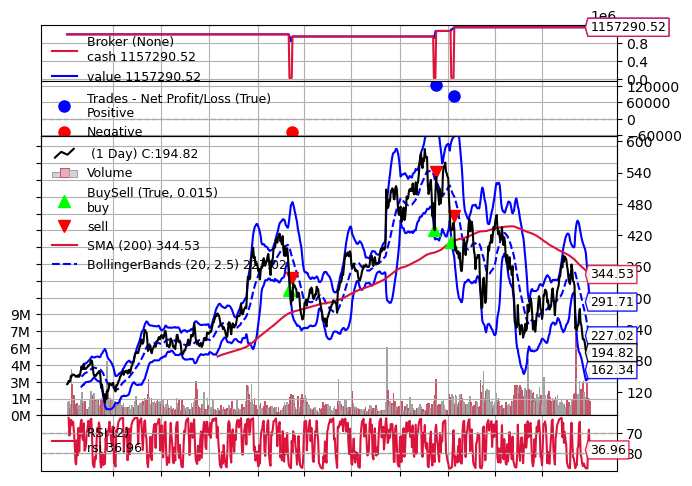

[[<Figure size 640x480 with 5 Axes>]]

In [73]:
# for %matplotlib widget to work, we need to install ipympl library: https://github.com/matplotlib/ipympl
%matplotlib inline
cerebro.plot(iplot=False)